In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd -q src

In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align

# Timething API

Here's an example use of the Timething API. Let's use it to take a look at the alignment for a single track. Let's set up:

In [3]:
# config
fixtures_path = Path("../fixtures")
aligments_path = fixtures_path / "alignments"
metadata = fixtures_path / "text.csv"
cfg = utils.load_config("english")
device = "cpu"

# aligner
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
aligner = align.Aligner.build(device, cfg)
ds.clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab)

# loader
loader = DataLoader(
    ds,
    batch_size=3,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

Let's pull up some recordings:

In [4]:
xs, ys, ys_original, ids  = next(iter(loader))

In [5]:
for y, y_original, id in zip(ys, ys_original, ids):
    print(f"{id}: '{y_original}'. Cleaned: '{y}'")
    display(ipd.Audio(fixtures_path / id))

audio/one.mp3: 'One!'. Cleaned: 'one'


audio/two.mp3: 'Two?'. Cleaned: 'two'


audio/born.mp3: 'Born in 1969 in Belgrade.'. Cleaned: 'born|in|nineteen|sixty-nine|in|belgrade'


Let's align them.

In [6]:
alignments = aligner.align((xs, ys, ys_original, ids))

/usr/local/Caskroom/miniforge/base/envs/timething/lib/python3.9/site-packages/transformers-4.4.2-py3.8.egg/transformers/models/wav2vec2/modeling_wav2vec2.py:704: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Let's pick one example:

In [7]:
recording_idx = 2
id = ids[recording_idx]
y = ys[recording_idx]
y_original = ys_original[recording_idx]
alignment = alignments[recording_idx]

First let's take a look at the frame-wise log probabilities.

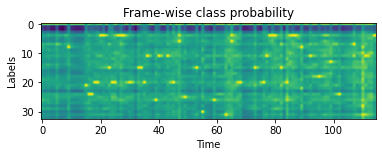

In [8]:
plt.imshow(alignment.scores)
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels");

Let's check the alignment plot:

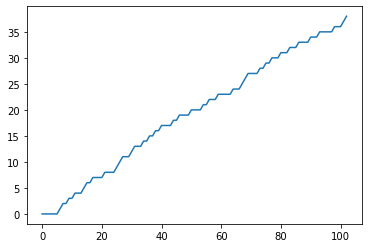

In [9]:
path = align.best(alignment.scores, aligner.tokens(y), aligner.blank_id)
plt.plot([b.i_transcript for b in path])

In [10]:
path

[BestPath(i_transcript=0, i_frame=9, path_score=1.30107614928018e-14, frame_score=0.9999846222381212),
 BestPath(i_transcript=0, i_frame=10, path_score=1.301073667676732e-14, frame_score=0.9999973774024795),
 BestPath(i_transcript=0, i_frame=11, path_score=1.301073667676732e-14, frame_score=0.9999991655356624),
 BestPath(i_transcript=0, i_frame=12, path_score=1.301073667676732e-14, frame_score=0.9999994039539004),
 BestPath(i_transcript=0, i_frame=13, path_score=1.301073667676732e-14, frame_score=0.9999996423722521),
 BestPath(i_transcript=0, i_frame=14, path_score=1.3010711860780175e-14, frame_score=0.9999986886995842),
 BestPath(i_transcript=1, i_frame=15, path_score=1.3010637413102734e-14, frame_score=0.9999949932351057),
 BestPath(i_transcript=2, i_frame=16, path_score=1.2281415138963524e-14, frame_score=0.9439519113515484),
 BestPath(i_transcript=2, i_frame=17, path_score=7.287688879271984e-16, frame_score=0.0001733039908179039),
 BestPath(i_transcript=3, i_frame=18, path_score=7.

In [11]:
align.to_segments(path, y)

[Segment(label='b', start=9, end=14, score=0.9999789003014741, geometric_score=0.9999957800246786),
 Segment(label='o', start=15, end=15, score=0.9999949932351057, geometric_score=0.9999949932351057),
 Segment(label='r', start=16, end=17, score=0.0001635906333774116, geometric_score=0.0001635906333774116),
 Segment(label='n', start=18, end=19, score=0.006015770992116981, geometric_score=0.006015770992116981),
 Segment(label='|', start=20, end=22, score=3.107038129833426e-06, geometric_score=0.001762679247575527),
 Segment(label='i', start=23, end=23, score=0.9998927231492597, geometric_score=0.9998927231492597),
 Segment(label='n', start=24, end=25, score=0.6426997185004676, geometric_score=0.6426997185004676),
 Segment(label='|', start=26, end=29, score=4.571486896482561e-08, geometric_score=0.003575629346938418),
 Segment(label='n', start=30, end=33, score=0.7463006798533869, geometric_score=0.9070640312360948),
 Segment(label='i', start=34, end=34, score=0.9999502921986438, geometri

In [12]:
alignment.chars_cleaned

[Segment(label='b', start=9, end=14, score=0.9999789003014741, geometric_score=0.9999957800246786),
 Segment(label='o', start=15, end=15, score=0.9999949932351057, geometric_score=0.9999949932351057),
 Segment(label='r', start=16, end=17, score=0.0001635906333774116, geometric_score=0.0001635906333774116),
 Segment(label='n', start=18, end=19, score=0.006015770992116981, geometric_score=0.006015770992116981),
 Segment(label='|', start=20, end=22, score=3.107038129833426e-06, geometric_score=0.001762679247575527),
 Segment(label='i', start=23, end=23, score=0.9998927231492597, geometric_score=0.9998927231492597),
 Segment(label='n', start=24, end=25, score=0.6426997185004676, geometric_score=0.6426997185004676),
 Segment(label='|', start=26, end=29, score=4.571486896482561e-08, geometric_score=0.003575629346938418),
 Segment(label='n', start=30, end=33, score=0.7463006798533869, geometric_score=0.9070640312360948),
 Segment(label='i', start=34, end=34, score=0.9999502921986438, geometri

In [13]:
alignment.words_cleaned

[Segment(label='born', start=9, end=19, score=9.840980949661983e-07, geometric_score=0.03149630430406005),
 Segment(label='in', start=23, end=25, score=0.6426307716986952, geometric_score=0.8016425460881522),
 Segment(label='nineteen', start=30, end=46, score=0.7428094891745589, geometric_score=0.9635176628401216),
 Segment(label='sixty-nine', start=49, end=77, score=0.6257704210489974, geometric_score=0.9542045939416467),
 Segment(label='in', start=82, end=85, score=0.8165857534148053, geometric_score=0.9036513450522858),
 Segment(label='belgrade', start=89, end=111, score=0.03255662810519938, geometric_score=0.6517483304398375)]

In [14]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_words(words):
    for word in words:
        start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
        end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
        y, sr = utils.load_slice(fixtures_path / id, start_seconds, end_seconds)
        print(f"{word.label} ({word.start}:{word.end})")
        ipd.display(ipd.Audio(y, rate=sr))
        
show_words(alignment.words_cleaned)

born (9:19)


in (23:25)


nineteen (30:46)


sixty-nine (49:77)


in (82:85)


belgrade (89:111)


Looks reasonable. Now for the original versions:

In [15]:
alignment.chars

[Segment(label='B', start=9, end=14, score=0.9999789003014741, geometric_score=0.9999957800246786),
 Segment(label='o', start=15, end=15, score=0.9999949932351057, geometric_score=0.9999949932351057),
 Segment(label='r', start=16, end=17, score=0.0001635906333774116, geometric_score=0.0001635906333774116),
 Segment(label='n', start=18, end=19, score=0.006015770992116981, geometric_score=0.006015770992116981),
 Segment(label=' ', start=20, end=22, score=3.107038129833426e-06, geometric_score=0.001762679247575527),
 Segment(label='i', start=23, end=23, score=0.9998927231492597, geometric_score=0.9998927231492597),
 Segment(label='n', start=24, end=25, score=0.6426997185004676, geometric_score=0.6426997185004676),
 Segment(label=' ', start=26, end=29, score=4.571486896482561e-08, geometric_score=0.003575629346938418),
 Segment(label='1969', start=30, end=77, score=0.7463006798533869, geometric_score=0.9070640312360948),
 Segment(label=' ', start=78, end=81, score=3.0343236837087607e-06, g

In [16]:
alignment.words

[Segment(label='Born', start=9, end=19, score=9.840980949661983e-07, geometric_score=0.03149630430406005),
 Segment(label='in', start=23, end=25, score=0.6426307716986952, geometric_score=0.8016425460881522),
 Segment(label='1969', start=30, end=77, score=0.7463006798533869, geometric_score=0.7463006798533869),
 Segment(label='in', start=82, end=85, score=0.8165857534148053, geometric_score=0.9036513450522858),
 Segment(label='Belgrade.', start=89, end=111, score=0.03255662810519938, geometric_score=0.6517483304398375)]

In [17]:
show_words(alignment.words)

Born (9:19)


in (23:25)


1969 (30:77)


in (82:85)


Belgrade. (89:111)
